# Определение стоимости автомобилей

**План проекта:**
        
1. Описание задачи 
2. Анализ данных
3. Подготовка данных
4. Обучение моделей
5. Анализ моделей
6. Тестирование лучшей модели
7. Итоговый вывод

## 1 Описание задачи

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Задача построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**  
  
Данные находятся в файле `autos.csv`.  
  
**Признаки:**  
  

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя  
  
**Целевой признак:**  
  
- `Price` — цена (евро)
  
При изучение данных важно заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.

## 2 Анализ данных

Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Удалим неинформативные признаки.

### 2.1 Загрузка, ознакомление и удаление неинформативных признаков

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# прочитаем датасеты

try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/datasets/autos.csv')

In [3]:
# посмотрим данные

data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Мы имеем следующие данные:

**Признаки**  
  
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя  
  
**Целевой признак**  
  
- `Price` — цена (евро)  
   
Из них видно, что для исследования не понадобяться дата скачивания анкеты, дата создания анкеты, количество фотографий автомобиля, почтовый индекс, дата последней активности пользователя. А так же бросается в глаза не удобное наименование столбцов. Поэтому перед исследованием данных удалим лишнее и приведем к змеиному регистру оставшиеся столбцы.

In [4]:
# удалим лишние столбцы

data = data.drop(columns=['DateCrawled','DateCreated','NumberOfPictures','PostalCode', 'LastSeen'])

In [5]:
# проверим удаление

data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [6]:
# приведем наименования столбцов к нижнему регистру

data.columns = map(str.lower, data.columns)
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [7]:
# переименуем те наименования, где не соблюдем змеиный регистр

data = data.rename(columns={'vehicletype':'vehicle_type', 
                            'registrationyear':'registration_year', 
                            'registrationmonth':'registration_month',
                            'fueltype':'fuel_type'})
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

Теперь мы имеем только нужную информацию и верное написание наименований, можно переходить к анализу данных и работе с ними.

In [8]:
# посмотрим на типы данных и на пропуски

print(data.info())
print()
print(data.isna().sum())
print()
print('Дубликаты:',data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  repaired            283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB
None

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0

У нас 11 столбцов и 354369 строк. Типы данных верные.  Есть пропуски в типе кузова, типе коробки передач,  модели, типе топлива, был ремонт или нет. И 27543 явных дубликатов.  
Удалим дубликаты и проработаем пропуски в оставшихся данных. 

In [9]:
# удалим явные дубликаты

data = data.drop_duplicates()
data.duplicated().sum()

0

### 2.2 Удаление пропусков

In [10]:
# посмотрим какие уникальные значения у нас имеются в типе кузова

data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
# посмотрим пропуски в процентном соотношении

(data['vehicle_type'].isna().sum() / data.shape[0]).round(3)

0.108

У нас почти 11% пропущенных значений. Переименуем их так, чтобы с ними можно было работать и посмотрим какие модели навскидку не имеют указания типа. 

In [12]:
# переименуем пропущенные значения в типа кузова

data['vehicle_type'] = data['vehicle_type'].fillna('not_indicated')
data['vehicle_type'].value_counts()

sedan            83602
small            73496
wagon            59662
not_indicated    35249
bus              26795
convertible      18752
coupe            15120
suv              10977
other             3173
Name: vehicle_type, dtype: int64

In [13]:
# посмотрим, какие автомобили попали под не указанный кузов

data[data['vehicle_type'] == 'not_indicated']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,not_indicated,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
16,300,not_indicated,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
22,2900,not_indicated,2018,manual,90,meriva,150000,5,petrol,opel,no
26,5555,not_indicated,2017,manual,125,c4,125000,4,NaN,citroen,no
31,899,not_indicated,2016,manual,60,clio,150000,6,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354346,2600,not_indicated,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
354351,1900,not_indicated,2000,manual,110,NaN,150000,7,NaN,volkswagen,no
354361,5250,not_indicated,2016,auto,150,159,150000,12,NaN,alfa_romeo,no
354364,0,not_indicated,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes


In [14]:
# посмотрим на уникальные значения в типе кузова

data['vehicle_type'].unique()

array(['not_indicated', 'coupe', 'suv', 'small', 'sedan', 'convertible',
       'bus', 'wagon', 'other'], dtype=object)

In [15]:
# посмотрим на уникальные значения в типе коробки передач

data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [16]:
# посмотрим пропуски в процентном соотношении

(data['gearbox'].isna().sum() / data.shape[0]).round(3)

0.054

Процент небольшой, всего лишь 5, при этом коробка передач влияет на стоимость автомобиля. Механика стоит дешевле автомата, а  полу-автомат ломается чаще и это тоже влияет на стоимость. Без коробки передач данные не полные и в нашей задаче никак не помогут. Поэтому удаляем. 

In [17]:
# удалим пропуски в моделях

data.dropna(subset=['gearbox'], inplace=True)
data['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [18]:
# посмотрим на уникальные значения в модели

data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta', 'c_klasse',
       'micra', 'vito', 'sprinter', '156', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'combo', 'focus', 'tt', 'a6',
       'jazz', 'omega', 'slk', '7er', 'corsa', '80', '147', 'z_reihe',
       'sportage', 'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'insignia', 'ka', 'almera', 'megane', 'a3', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'sharan', '6_reihe',
       'panda', 'up', 'seicento', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz',
      

In [19]:
# посмотрим пропуски в процентном соотношении

(data['model'].isna().sum() / data.shape[0]).round(3)

0.049

Мы имеем небольшой процент пропусков и к тому же без наименования модели данные по авто не имеют смысла, так что здесь можно смело удалять пропуски.

In [20]:
# удалим пропуски в моделях

data.dropna(subset=['model'], inplace=True)
data['model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta', 'c_klasse',
       'micra', 'vito', 'sprinter', '156', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'combo', 'focus', 'tt', 'a6',
       'jazz', 'omega', 'slk', '7er', 'corsa', '80', '147', 'z_reihe',
       'sportage', 'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'insignia', 'ka', 'almera', 'megane', 'a3', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'sharan', '6_reihe',
       'panda', 'up', 'seicento', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz',
       'bee

In [21]:
# посмотрим на уникальные значения в типе топлива

data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [22]:
# посмотрим пропуски в процентном соотношении

(data['fuel_type'].isna().sum() / data.shape[0]).round(3)

0.065

Собственно,тут у нас таквя же ситуация - всего 7% пропусков от всех данных и без типа топлива трудно вычислиь стоимость авто, так как этот показатель влияет на нее напрямую. Вывод - удаляем пропуски. 

In [23]:
# удалим пропуски в типе топлива

data.dropna(subset=['fuel_type'], inplace=True)
data['fuel_type'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [24]:
# посмотрим на уникальные значения в столбце с ремонтом

data['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [25]:
# посмотрим пропуски в процентном соотношении

(data['repaired'].isna().sum() / data.shape[0]).round(3)

0.155

В данном случае в реальной задаче я бы обратилась к предоставивишм данные для разьяснения, какой именно ремонт имеется ввиду. Ведь одно дело в целом ремонт или после аварии. К тому же важно, что конкретно ремонтировали. Например, бампер не будет так сильно влиять так как это не железная часть, а вот вмятина двери - будет.  
  
В учебной задаче предлагаю предположить, что имеется ввиду капитальный ремонт после аварии и тогда стоит удалить пропуски, так как это очень сильно влияющий фактор на цену. 

In [26]:
# удалим пропуски 

#data.dropna(subset=['repaired'], inplace=True)

data['repaired'] = data['repaired'].fillna('not_specified')
data['repaired'].unique()

array(['not_specified', 'no', 'yes'], dtype=object)

In [27]:
# проверим все ли пропуски мы обработали

data.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

### 2.3 Проверка данных на аномальные значения

Теперь посмотрим оставшиеся столбцы на наличие аномалий в данных.

In [28]:
# проверим год выпуска автомобилей

data['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 1980, 2014, 2005, 2011, 2007, 2009,
       2002, 2018, 1997, 1990, 1981, 2003, 2016, 1984, 2006, 1999, 1998,
       2017, 2012, 2010, 2000, 1992, 2013, 1994, 1991, 1996, 1989, 2015,
       1985, 1982, 1983, 1973, 1969, 1971, 1987, 1988, 1986, 1965, 1970,
       1945, 1974, 1955, 1978, 1976, 1979, 1972, 1977, 1961, 1966, 1975,
       1963, 1954, 1967, 1960, 1964, 1910, 1968, 1962, 1937, 1951, 1953,
       2019, 1959, 1958, 1956, 2900, 1400, 1950, 1200, 1932, 1952, 3700,
       5000, 1942, 1935, 6500, 1957, 1923, 1930, 1943, 1934, 1938, 9000,
       1936, 1000, 1919, 1929, 6000, 1928, 1931, 1927, 1933, 1947, 7500,
       1600])

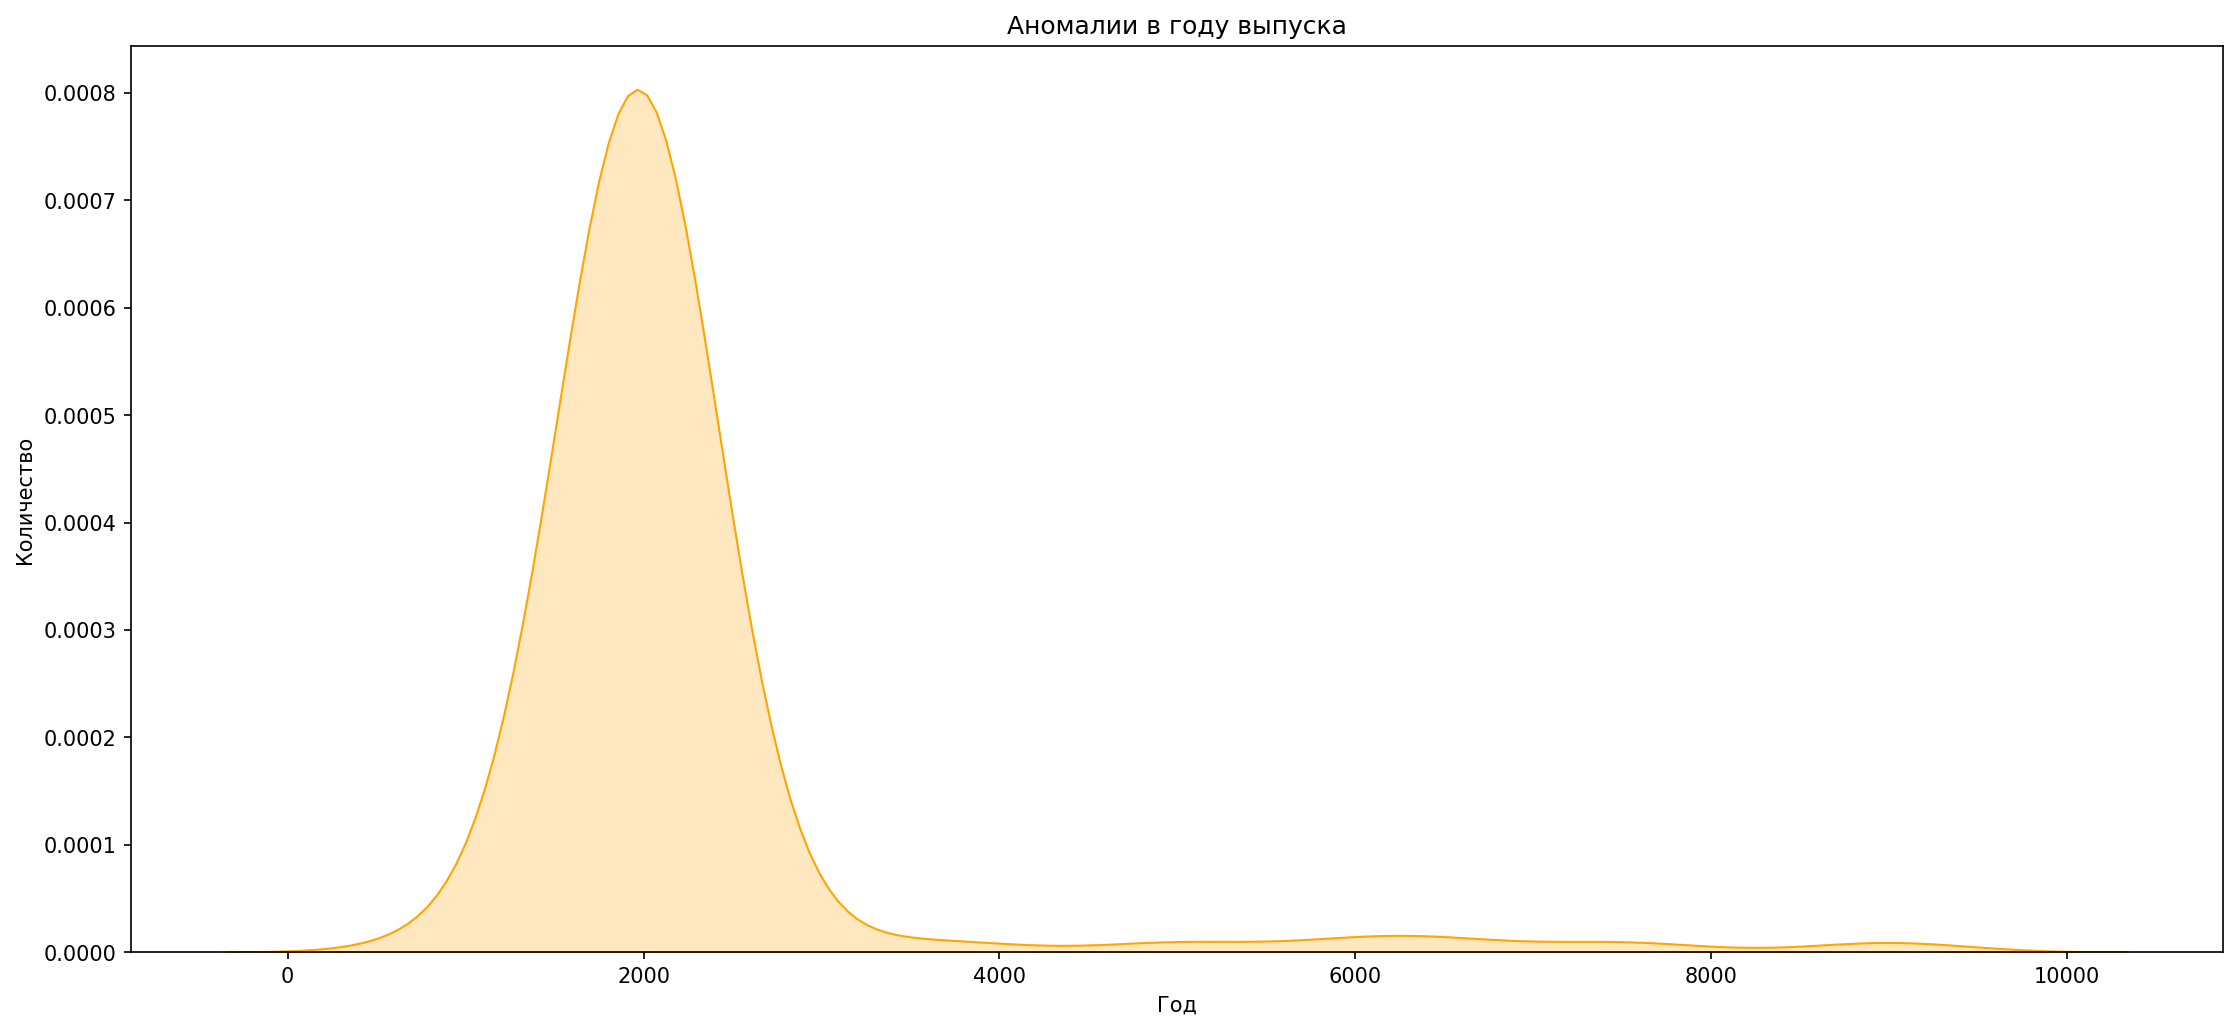

In [29]:
# построим график распределения регистрации по годам

plt.figure(figsize=(18, 8), dpi=150); 

sns.kdeplot(data=data['registration_year'].unique(), fill=True , color = "Orange", common_grid=True)

plt.title('Аномалии в году выпуска')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show();

У нас есть очевидные аномалии - слишком старые автомобили и выпуска 4000, 6000 и тд годов. Сделаем выборку для нашей задачи только из адекватных годов выпуска. Автомобили старше 30 лет считаются раритетными, то есть цены и спрос на них уже строиться по другим законам. Поэтому возьмем промежуток с 1989 по 2019 год. Так как дальше 2019 у нас только аномалии. 

In [30]:
# выделим года с 1989 по 2017

data = data.query('registration_year >= 1989 & registration_year < 2017')
data['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 2005, 2011, 2007, 2009, 2002,
       1997, 1990, 2003, 2016, 2006, 1999, 1998, 2012, 2010, 2000, 1992,
       2013, 1994, 1991, 1996, 1989, 2015])

In [31]:
# проверим месяц выпуска автомобилей и количесто авто в эти месяца

print(data['registration_month'].unique())
print()
print(data.groupby('registration_month')['price'].nunique())

[ 0  8  6  7 10 12 11  3  2  1  4  5  9]

registration_month
0      795
1     1193
2     1166
3     1403
4     1357
5     1323
6     1363
7     1290
8     1233
9     1269
10    1287
11    1270
12    1238
Name: price, dtype: int64


In [32]:
# выведем нулевой месяц и посомтрим на другие данные

data[data['registration_month'] == 0]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,not_indicated,1993,manual,0,golf,150000,0,petrol,volkswagen,not_specified
80,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes
129,300,small,2000,manual,54,corsa,150000,0,petrol,opel,not_specified
168,950,sedan,1995,manual,115,5er,150000,0,petrol,bmw,not_specified
181,3000,not_indicated,2016,auto,75,fabia,150000,0,petrol,skoda,not_specified
...,...,...,...,...,...,...,...,...,...,...,...
354204,250,wagon,1993,manual,75,golf,150000,0,petrol,volkswagen,no
354206,1700,sedan,1997,manual,101,a4,150000,0,petrol,audi,yes
354270,9000,wagon,2005,manual,0,a6,150000,0,gasoline,audi,not_specified
354297,400,wagon,1996,manual,150,a4,150000,0,petrol,audi,not_specified


Для нулевых месяцев указан год выпуска, этого вполне достаточно для наших целей. Оставляем все как есть.

In [33]:
# проверим мощность на аномалии

data['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'mini', 'smart', 'opel', 'audi', 'alfa_romeo', 'subaru', 'volvo',
       'mitsubishi', 'kia', 'hyundai', 'lancia', 'citroen', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [34]:
# проверим мощность на аномалии

data['model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'twingo', 'a_klasse', 'scirocco', '5er',
       'arosa', 'other', 'civic', 'punto', 'e_klasse', 'clio', 'one',
       'fortwo', '1er', 'b_klasse', 'astra', 'a8', 'jetta', 'polo',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'combo', 'focus',
       'tt', 'a6', 'jazz', 'transporter', 'slk', '7er', 'corsa', '80',
       '147', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'insignia', 'ka', 'almera', 'megane',
       'a3', 'lupo', 'r19', 'mondeo', 'colt', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', 'modus', 'fox', 'matiz', 'beetle', 'rio', 'touareg',
       'logan', 'caddy', 'omega', 'cuore', 's_max', 'a2', 'galaxy', 'c3',
       

С маркой и моделями все в порядке. Опираясь на них можно сделать вывод об аномалиях в мощностях.

In [35]:
# проверим мощность на аномалии

data['power'].unique()

array([    0,   163,    75,    69,   102,   109,   125,   105,   140,
         115,   190,   136,   160,   231,    50,   118,   193,    99,
          60,   113,   218,   122,   129,    95,    61,   177,   170,
         143,   101,   232,   156,    80,    82,    90,   155,   150,
         185,    87,    86,   131,   224,   235,   200,   178,   265,
          77,   110,   120,    54,   286,   116,   184,   204,    88,
         194,    64,   305,   197,   179,   250,   313,    45,    98,
         130,   114,   211,    56,   201,   213,   107,   174,   100,
         220,    73,    41,   192,    66,    74,    58,    52,   147,
          71,    97,    65,   239,    68,   203,   144,   300,   103,
          85,   258,   320,    63,    81,   148,    83,    70,   145,
          55,   180,   280,   260,   104,   306,   188,   333,   117,
         141,   132,   165,   234,   158,    39,    92,    51,   135,
          59,   230,    53,    84,   209,    43,   146,    67,   106,
         276,   344,

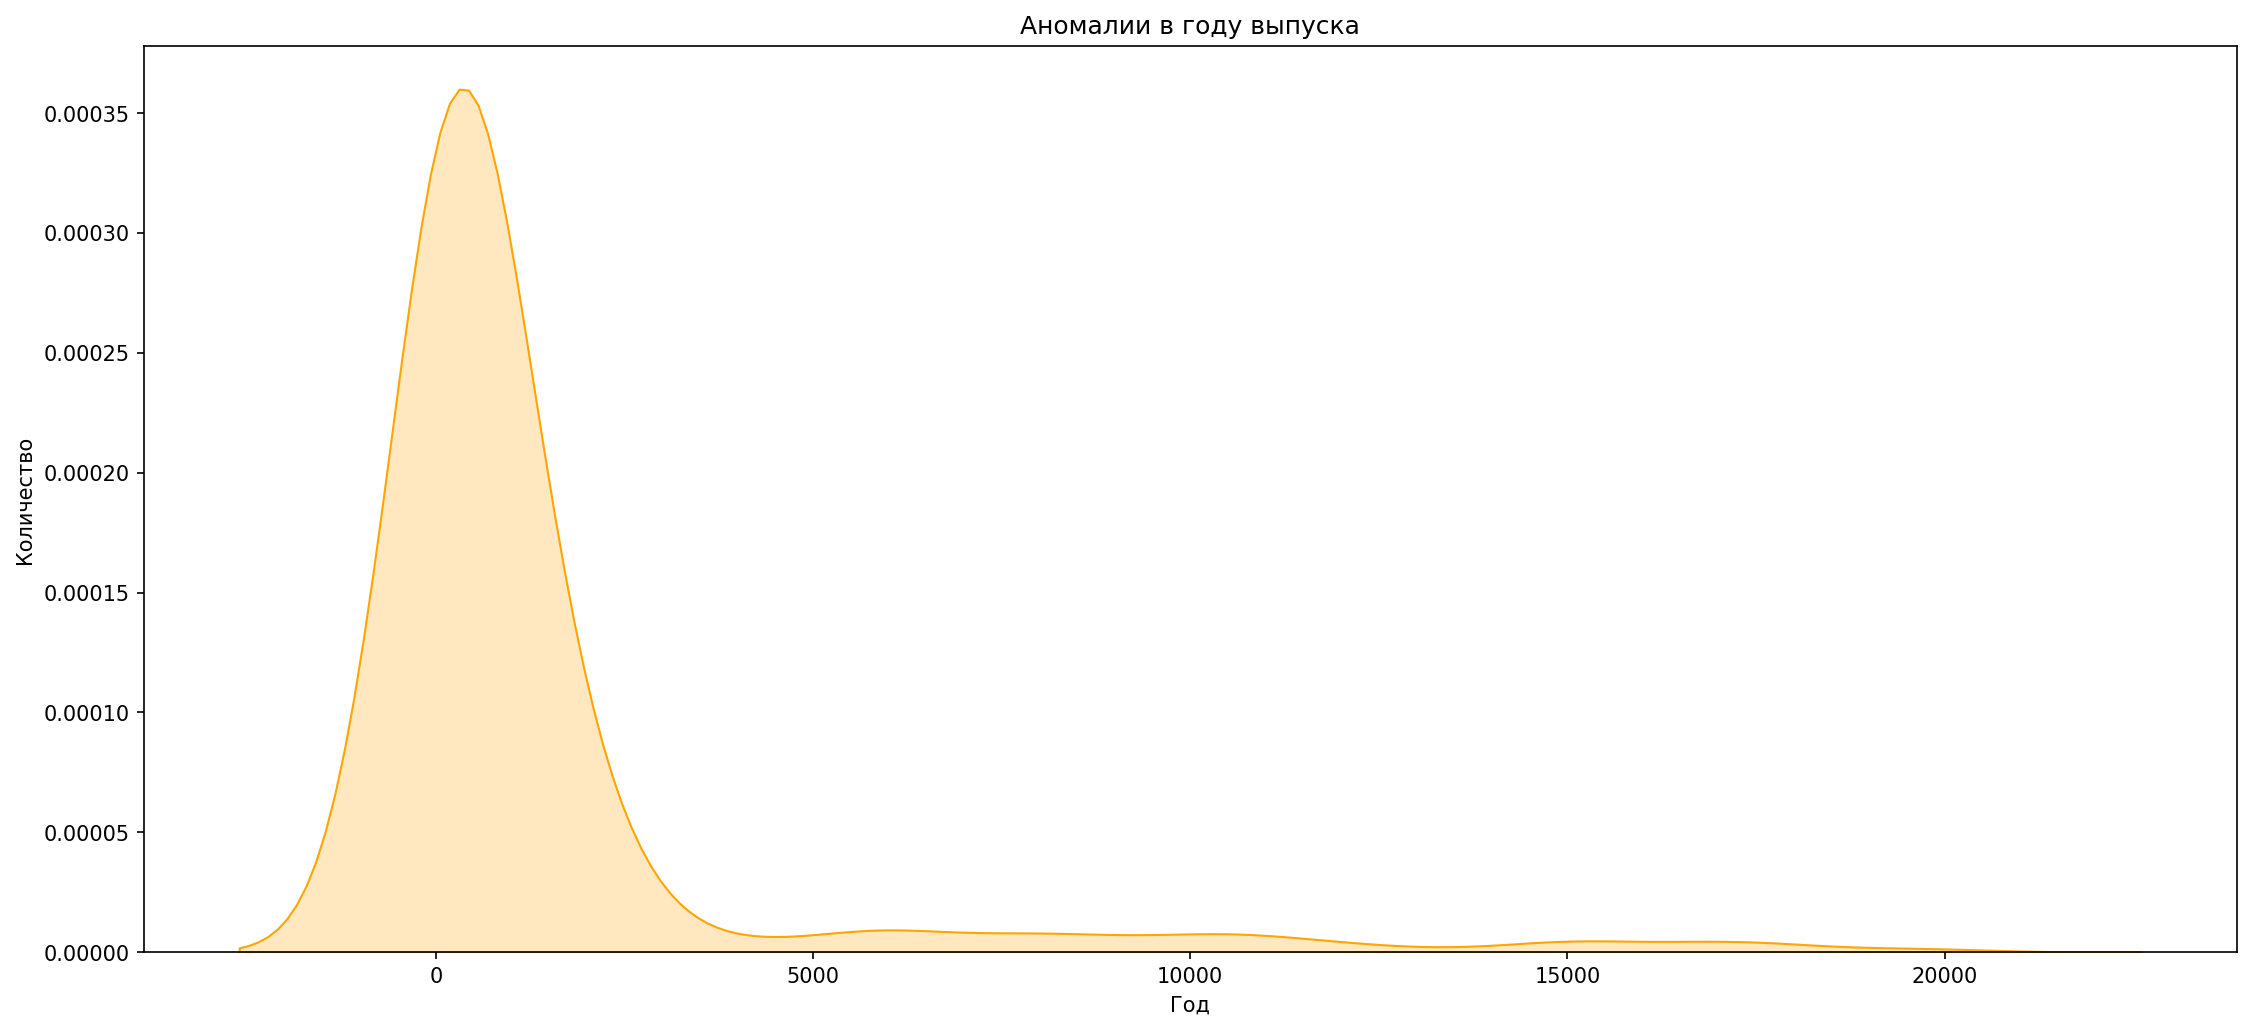

In [36]:
# построим график мощностей

plt.figure(figsize=(18, 8), dpi=150); 

sns.kdeplot(data=data['power'].unique(), fill=True , color = "Orange", common_grid=True)

plt.title('Аномалии в году выпуска')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show();

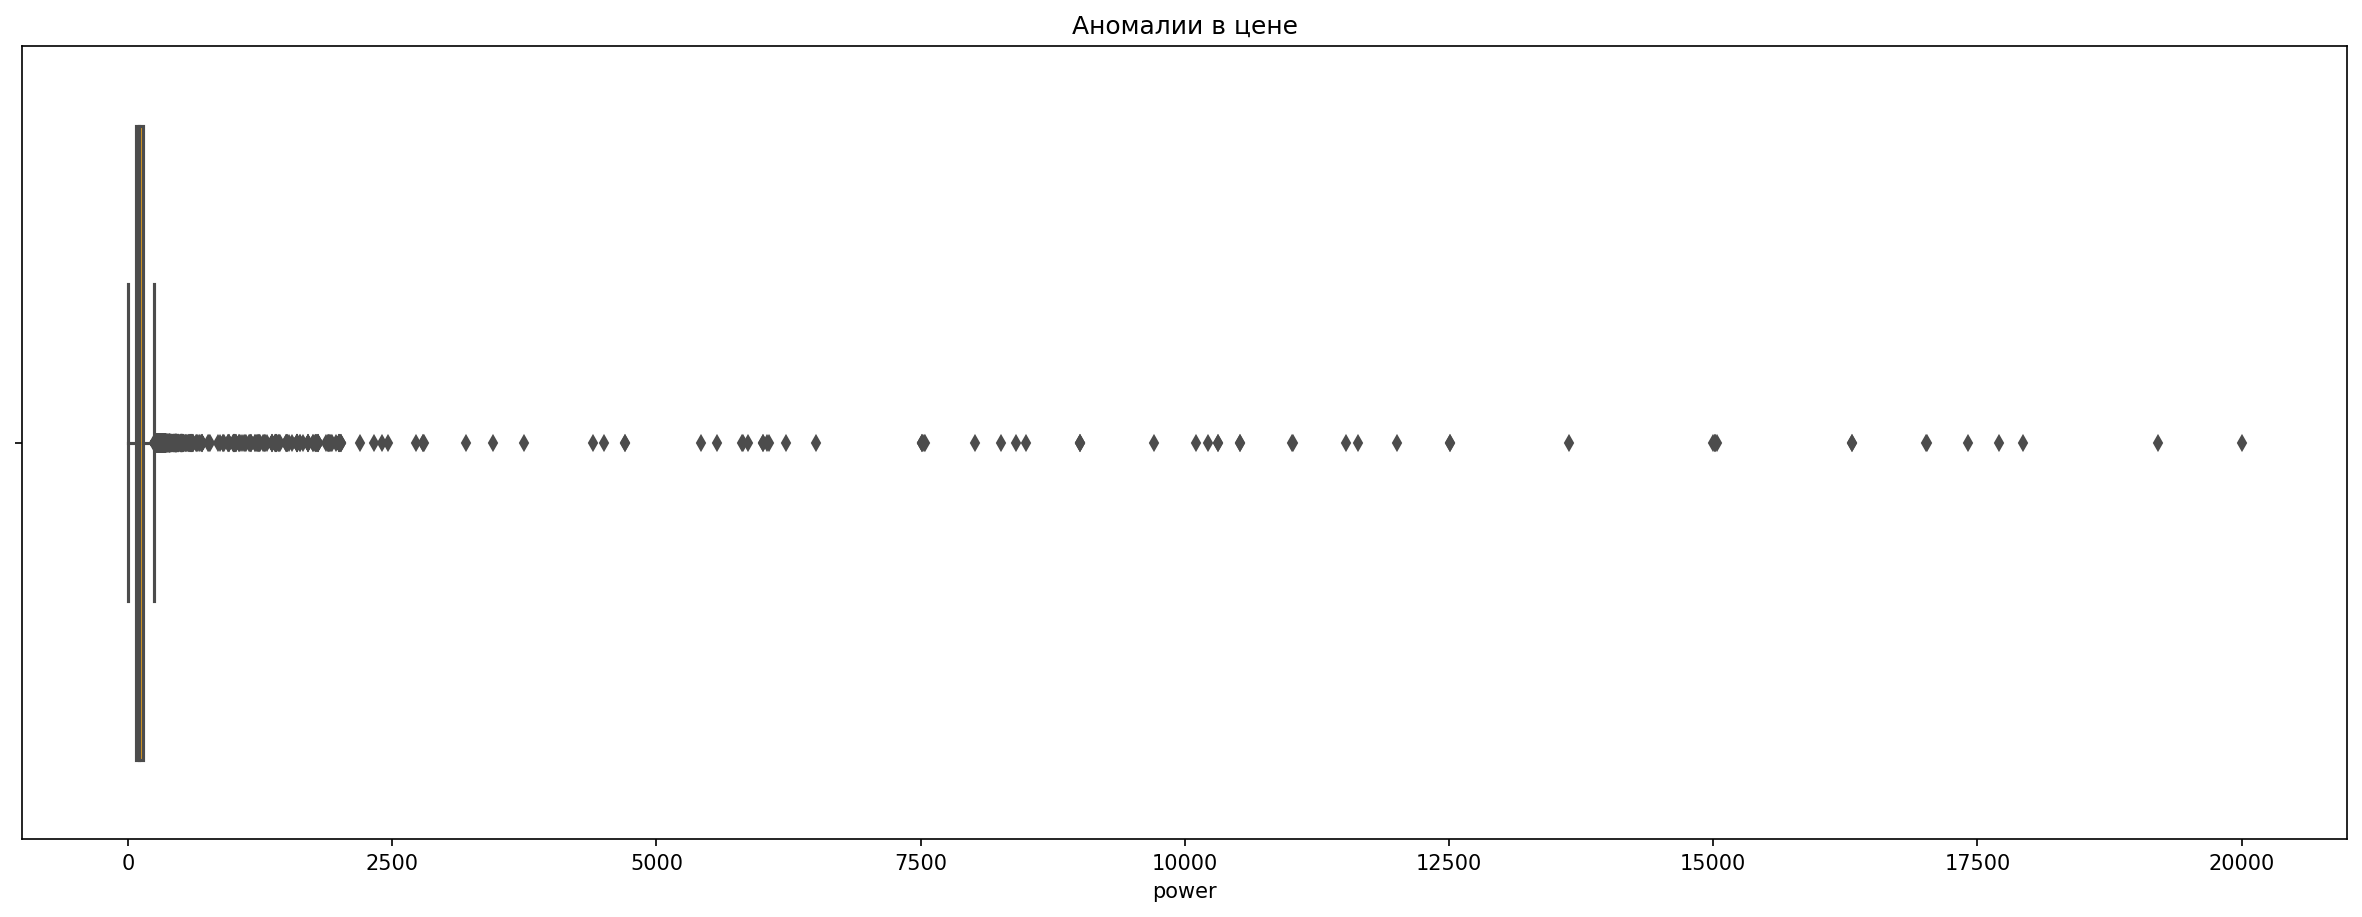

In [37]:
# построим график ящик с усами для мощностей

plt.figure(figsize=(20, 7), dpi=150); 

sns.boxplot(data['power'], color = "Orange")

plt.title('Аномалии в цене')
plt.show()

Итак, мы видим аномалии. Среди марок у нас нет автомобилей типа ламборджини или буггати, значит лошадиных сил у нашей подборки будет стандартное количество. Из поиска в интернете я нашла, что 27 лет назад можно было купить автомобиль чуть меньше 50 л.с. И что свыше 1100 л.с. уже идут автомобили серийного производства. Идеально было бы прокнсулироваться с коллегой, предоставившим данные, но в учебных целях доверимся интернету. Исходя из этого наш интервал от 50 л.с. до 1100 л.с. 

In [38]:
# выделим л.с. от 50 до 1100

data = data.query('power >= 50 & power < 1100')
data['power'].unique()

array([ 163,   75,   69,  102,  109,  125,  105,  140,  115,  190,  136,
        160,  231,   50,  118,  193,   99,   60,  113,  218,  122,  129,
         95,   61,  177,  170,  143,  101,  232,  156,   80,   82,   90,
        155,  150,  185,   87,   86,  131,  224,  235,  200,  178,  265,
         77,  110,  120,   54,  286,  116,  184,  204,   88,  194,   64,
        305,  197,  179,  250,  313,   98,  130,  114,  211,   56,  201,
        213,  107,  174,  100,  220,   73,  192,   66,   74,   58,   52,
        147,   71,   97,   65,  239,   68,  203,  144,  300,  103,   85,
        258,  320,   63,   81,  148,   83,   70,  145,   55,  180,  280,
        260,  104,  306,  188,  333,  117,  141,  132,  165,  234,  158,
         92,   51,  135,   59,  230,   53,   84,  209,  146,   67,  106,
        276,  344,  237,  245,  111,  299,  326,  279,  138,  175,  226,
        126,  301,  166,  334,  128,  133,  124,  219,  241,  167,  182,
        196,  238,  228,   96,  272,  139,  240,   

In [39]:
# проверим пробег на аномалии

data['kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,  20000,
        80000,  50000,  40000,   5000,  10000])

Конечно, пробег в 5-20-30000 вызывает вопросы, но это может быть автомобиль, который в основном стоит в гараже. Оставим эти данные.

In [40]:
# проверим цены на аномалии

print(data['price'].unique())
print()
print(data['price'].value_counts().sort_values())

[ 9800  1500  3600 ... 12395 18429 10985]

8188        1
3440        1
5775        1
9333        1
11380       1
         ... 
1200     2896
2500     2909
500      3298
1500     3440
0        3727
Name: price, Length: 3464, dtype: int64


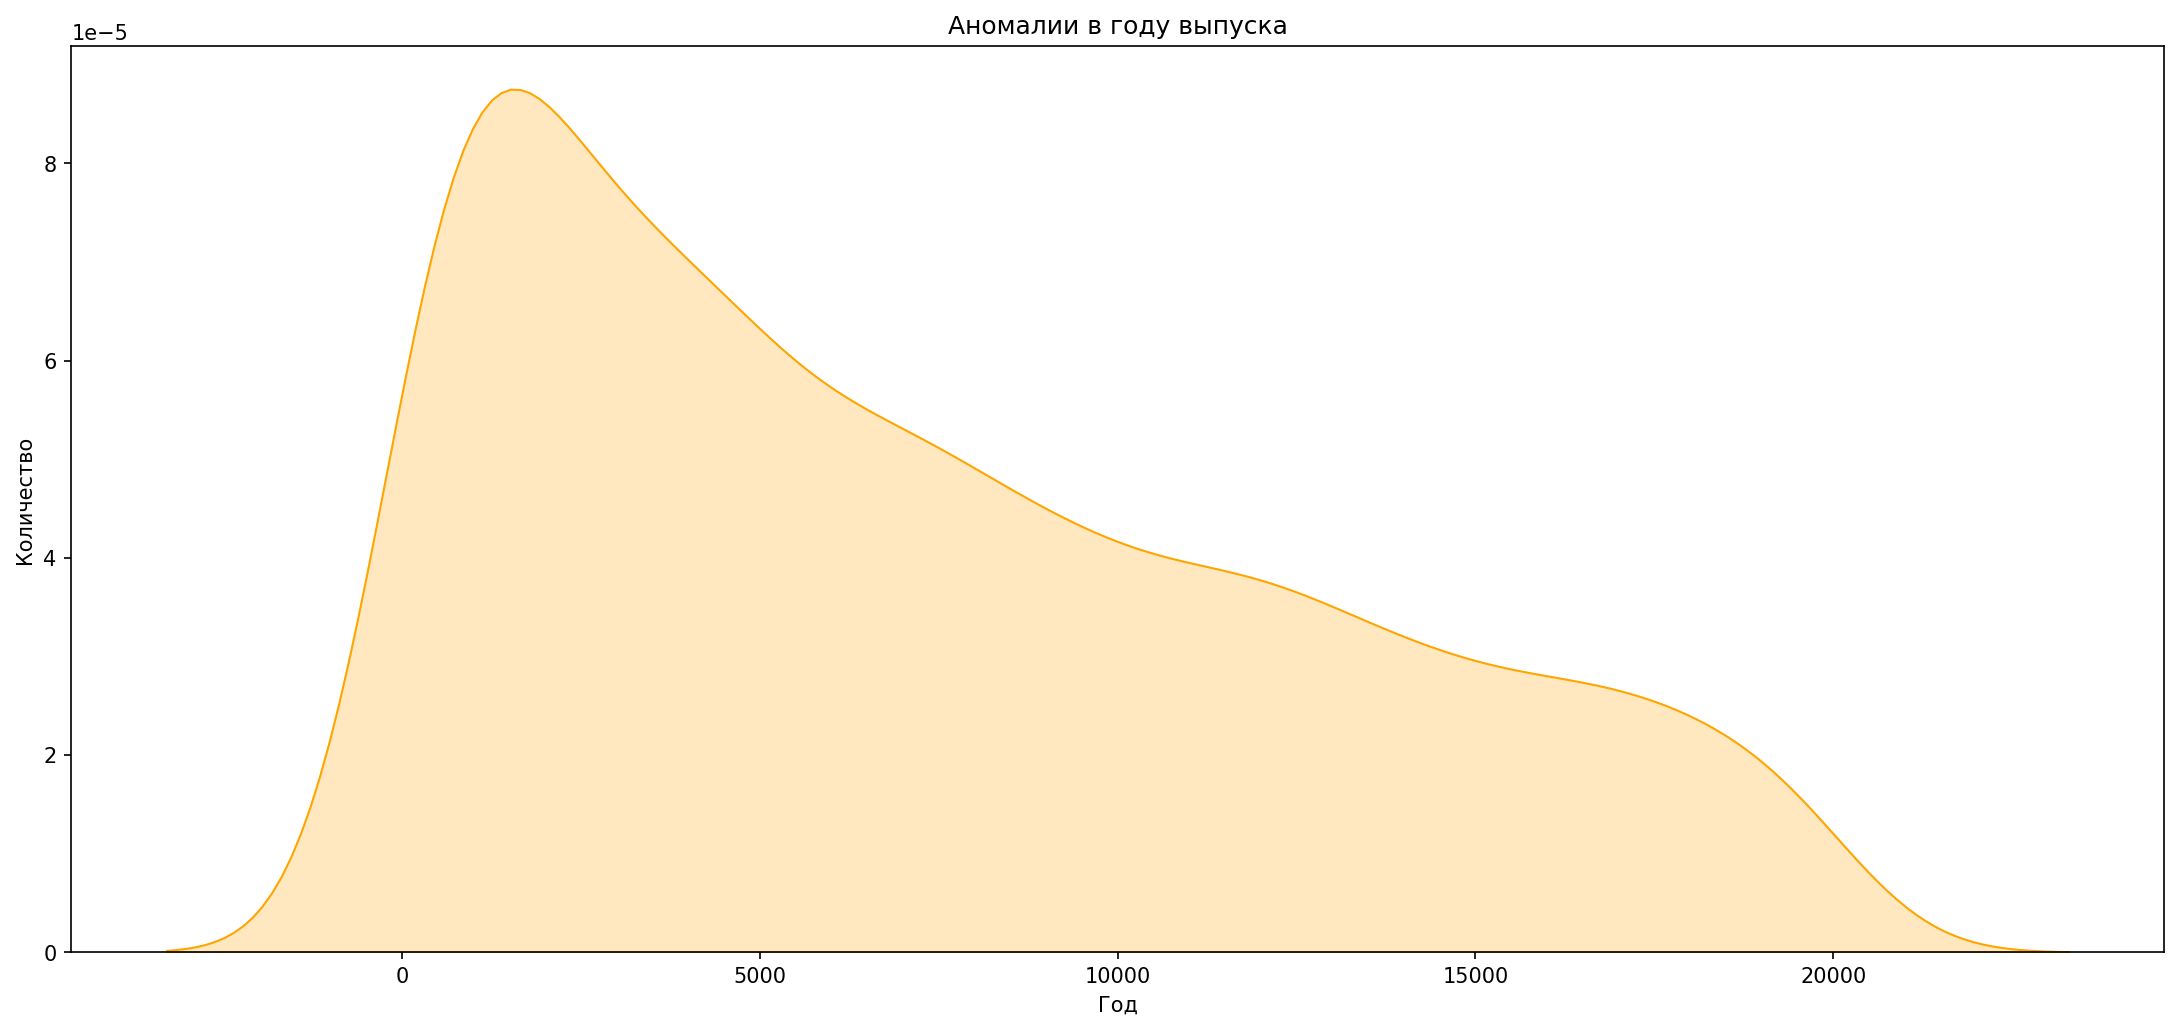

In [41]:
# построим график цен

plt.figure(figsize=(18, 8), dpi=150); 

sns.kdeplot(data=data['price'].unique(), fill=True , color = "Orange", common_grid=True)

plt.title('Аномалии в году выпуска')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show();

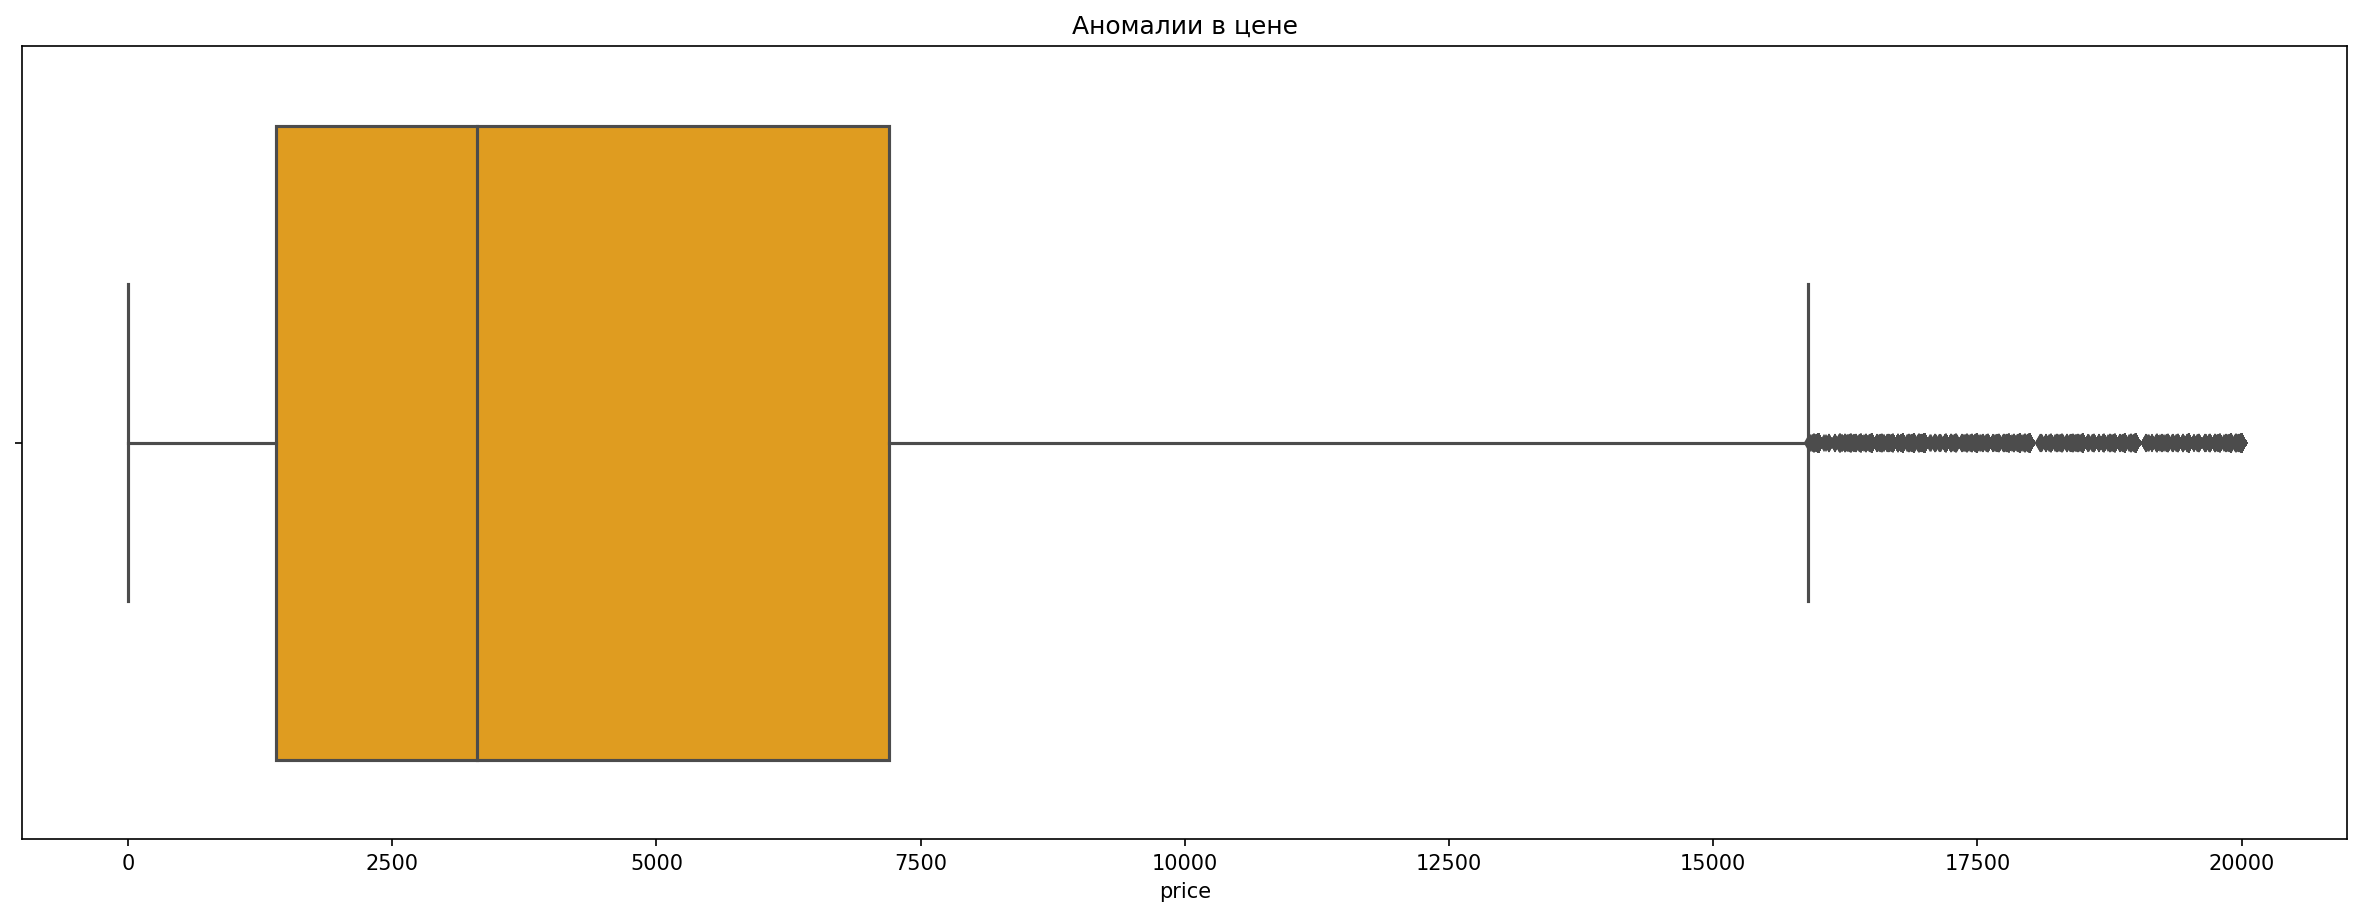

In [42]:
# посмотрим аномалии в цене на графике ящик с усами

plt.figure(figsize=(20, 7), dpi=150); 

sns.boxplot(data['price'], color = "Orange")

plt.title('Аномалии в цене')
plt.show()

У нас есть цены 0 и ниже него, а это не возможно. И дальше мы видим выбросы около 20000 евро. В принципе даже на сегодняшний день 20000 евро это 1 600 000 с чем-то, что вполне может быть правдой для наших данных. Но мы все же видим выбромы на графике с учами. Поэтому оставим данные от 1000 до 15000 евро

In [43]:
# выделим цены от 1000 до 18000

data = data.query('price >= 1000 & price < 15000')

Мы проверили все столбцы на пропуски и аномалии и обработали их. Посмотрим теперь, что у нас отсалость в данных.

In [44]:
# выведем 10 первых строк

data.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not_specified
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,not_specified
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes
17,1750,small,2004,auto,75,twingo,150000,2,petrol,renault,no
18,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no
19,1850,bus,2004,manual,102,a_klasse,150000,1,petrol,mercedes_benz,no


In [45]:
# выведем информацию о данных

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186368 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               186368 non-null  int64 
 1   vehicle_type        186368 non-null  object
 2   registration_year   186368 non-null  int64 
 3   gearbox             186368 non-null  object
 4   power               186368 non-null  int64 
 5   model               186368 non-null  object
 6   kilometer           186368 non-null  int64 
 7   registration_month  186368 non-null  int64 
 8   fuel_type           186368 non-null  object
 9   brand               186368 non-null  object
 10  repaired            186368 non-null  object
dtypes: int64(5), object(6)
memory usage: 17.1+ MB


### 2.4 Вывод по изучению данных   

Мы загрузили и изучили данные. На этом этапе:  
  
- удалены неинформативные признаки: дата скачивания анкеты, дата создания анкеты, количество фотографий автомобиля, почтовый индекс, дата последней активности пользователя
- наименования столбцов приведены к змеиному регистру
- обработаны пропуски в данных
- изучены и обработаны аномалии в данных  
   
В итоге мы получили датафрейм из 11 столбцов и 166318 строк. 

## 3 Подготовка данных для обучения моделей

На этом этапе мы подготовим данные для дальнейшей работы с моделями. Поскольку тестировать мы будем линейную модель, дерево и градиентный бустинг, то данные нужно подготовить для каждой из них.

### 3.1 Признаки и выборки 

In [46]:
# выделим признаки и целевой признак

features = data.drop(['price'], axis=1)
target = data['price']

In [47]:
# разобьем на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=12345)

In [48]:
# проверим размеры выборок

for data in [features_train, features_test, target_train, target_test]:
    print(data.shape)

(139776, 10)
(46592, 10)
(139776,)
(46592,)


### 3.2 OHE кодирование для линейной модели

In [49]:
# разобьем на обучающую и тестовую выборки

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features,
                                                                                            target,
                                                                                            test_size=.25,
                                                                                            random_state=12345)

In [50]:
# проверим размеры выборок

for data in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(data.shape)

(139776, 10)
(46592, 10)
(139776,)
(46592,)


In [51]:
# выполним прямое кодирование для линейных моделей

features_train_ohe = pd.get_dummies(features_train_ohe, drop_first=True)
features_test_ohe = pd.get_dummies(features_test_ohe, drop_first=True)

In [52]:
# проверим размеры выборок

for data in [features_train_ohe, features_test_ohe]:
    print(data.shape)

(139776, 303)
(46592, 294)


In [53]:
# после прямого кодирования кол-во признаков в выборках отличается
# поэтому выведем признаки, которых нет в тетостовой выборке

not_in_test_ohe = features_train_ohe.drop(columns=list(features_test_ohe.columns))
not_in_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139776 entries, 154620 to 139748
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   model_amarok              139776 non-null  uint8
 1   model_charade             139776 non-null  uint8
 2   model_elefantino          139776 non-null  uint8
 3   model_kalina              139776 non-null  uint8
 4   model_move                139776 non-null  uint8
 5   model_q3                  139776 non-null  uint8
 6   model_range_rover_evoque  139776 non-null  uint8
 7   model_rangerover          139776 non-null  uint8
 8   model_samara              139776 non-null  uint8
dtypes: uint8(9)
memory usage: 2.3 MB


In [54]:
# поэтому удалим лишние признаки в обучающей выборке

features_train_ohe = features_train_ohe.drop(columns=list(not_in_test_ohe.columns))

In [55]:
# проверим размеры выборок

for data in [features_train_ohe, features_test_ohe]:
    print(data.shape)

(139776, 294)
(46592, 294)


### 3.3 OE кодирование для модели дерева

In [56]:
# закодируем с помощью OrdinalEcoder категориальные признаки


encoder = OrdinalEncoder()
cat_columns = ['repaired', 'vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model']
encoder.fit(features_train[cat_columns])

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[cat_columns] = encoder.transform(features_train_oe[cat_columns])
features_test_oe[cat_columns] = encoder.transform(features_test_oe[cat_columns])

target_train_oe = target_train.copy()
target_test_oe = target_test.copy()

In [57]:
# проверим размеры выборок

for data in [features_train_oe, features_test_oe, target_train_oe, target_test_oe]:
    print(data.shape)

(139776, 10)
(46592, 10)
(139776,)
(46592,)


###  3.4 Масштабирование численных признаков

In [58]:
# стандартизируем численные признаки в обучающей выборке

numeric = ['power', 
           'kilometer', 
           'registration_year', 
           'registration_month']

scaler = StandardScaler()

scaler.fit(features_train[numeric])
scaler.fit(features_train_ohe[numeric])
scaler.fit(features_train_oe[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

features_train[numeric] = scaler.transform(features_train_oe[numeric])
features_test[numeric] = scaler.transform(features_test_oe[numeric])

### 3.5 Вывод по подготовке данных

На этом этапе мы:    
    
- разделили данные на признаки и целевой признак
- провели OHE кодирование для категориальных данных, с которыми в дальнейшем работали в линейной регрессии
- провели OE кодирование для категориальных данных, с которыми в дальнейшем работали в решающем дереве
- масштабировали численные признаки 

## 4 Обучение моделей

### 4.1 Линейная регрессия

In [59]:
%%time

# обучим модель линейной регрессии

start = time.time()

model_lin_reg = LinearRegression()
model_lin_reg.fit(features_train_ohe, target_train_ohe)

start_p = time.time()
prediction_lin_reg = model_lin_reg.predict(features_test_ohe)
predict_time_lin_reg = time.time() - start_p

rmse_lin_reg = mean_squared_error(target_test_ohe, prediction_lin_reg) ** .5

train_time_lin_reg = time.time() - start

print('RMSE:', round(rmse_lin_reg))
print('Время обучения:', round(train_time_lin_reg,2))
print('Время предсказания:', round(predict_time_lin_reg,2))

RMSE: 1888
Время обучения: 10.79
Время предсказания: 0.13
CPU times: user 6.41 s, sys: 4.4 s, total: 10.8 s
Wall time: 10.8 s


In [60]:
%%time

# обучим модель линейной регрессии с кросс-валидацией

start = time.time()

model_lin_reg_cv = LinearRegression()

start_p = time.time()

scores_lin_reg_cv = cross_val_score(model_lin_reg_cv,
                                    features_train_ohe, 
                                    target_train_ohe, 
                                    scoring='neg_root_mean_squared_error',
                                    cv=5)

predict_time_lin_reg_cv = time.time() - start_p

rmse_lin_reg_cv = np.mean(abs(scores_lin_reg_cv))

train_time_lin_reg_cv = time.time() - start

print('RMSE:', round(rmse_lin_reg_cv))
print('Время обучения:', round(train_time_lin_reg_cv,2))
print('Время предсказания:', round(predict_time_lin_reg_cv,2))

RMSE: 1908
Время обучения: 37.71
Время предсказания: 37.71
CPU times: user 24.1 s, sys: 13.4 s, total: 37.5 s
Wall time: 37.7 s


Для линейной регрессии мы получили:  
  
- стандартная модель RMSE 1888
- с кросс-валидацией RMSE 1908
  
Разница не большая, но адекватнее использовать вариант с кросс-валидацией, так как ранее мы не выделяли валидационную выборку. 

### 4.2 Дерево решений

In [61]:
state = RandomState(12345)

In [62]:
%%time

# обучим модель дерево решений

start = time.time()

best_model_tree = None
best_result_tree = 3000

for depth in range(1, 30, 1):
    
    model_tree = DecisionTreeRegressor(random_state=state, max_depth=depth)
    model_tree.fit(features_train_oe, target_train_oe) 
    
    start_p = time.time()
    
    prediction_tree = model_tree.predict(features_test_oe) 
    
    predict_time_tree = time.time() - start_p
    
    rmse_tree = (mean_squared_error(target_test_oe,prediction_tree))**0.5
    
    if rmse_tree < best_result_tree:
        best_model_tree = model_tree
        best_result_tree = rmse_tree

train_time_tree = time.time() - start

print('Параметры лучшей модели:', best_model_tree)
print()
print('RMSE:', round(best_result_tree))
print()
print('Время обучения:', round(train_time_tree,2))
print('Время предсказания:', round(predict_time_tree,2))

Параметры лучшей модели: DecisionTreeRegressor(max_depth=14,
                      random_state=RandomState(MT19937) at 0x7EFD80521940)

RMSE: 1582

Время обучения: 10.9
Время предсказания: 0.02
CPU times: user 10.8 s, sys: 72.3 ms, total: 10.9 s
Wall time: 10.9 s


In [63]:
%%time

# обучим модель дерево решений с кросс-валидацией

start = time.time()

best_model_tree_cv = None
best_result_tree_cv = 3000

scores_tree_cv = []

for depth in range(1, 30, 1):
    
    model_tree_cv = DecisionTreeRegressor(max_depth=depth, random_state=state)
    
    start_p = time.time()
    scores_tree_cv = cross_val_score(model_tree_cv,
                                     features_train_oe,
                                     target_train_oe,
                                     scoring='neg_root_mean_squared_error',
                                     cv=5)
    predict_time_tree_cv = time.time() - start_p

    rmse_tree_cv = np.mean(scores_tree_cv) * -1
    
    if rmse_tree_cv < best_result_tree_cv:
        best_model_tree_cv = model_tree_cv
        best_result_tree_cv = rmse_tree_cv
    
train_time_tree_cv = time.time() - start

print('Параметры лучшей модели:', best_model_tree_cv)
print()
print('RMSE:', round(best_result_tree_cv))
print()
print('Время обучения:', round(train_time_tree_cv,2))
print('Время предсказания:', round(predict_time_tree_cv,2))

Параметры лучшей модели: DecisionTreeRegressor(max_depth=13,
                      random_state=RandomState(MT19937) at 0x7EFD80521940)

RMSE: 1635

Время обучения: 44.02
Время предсказания: 2.29
CPU times: user 43.6 s, sys: 176 ms, total: 43.8 s
Wall time: 44 s


Для модели дерево решений получили:  
  
- стандартная модель RMSE 1582 с глубиной дерева 14
- с кросс-валидацией RMSE 1635 с глубиной дерева 13
  
Стандартнное обучение показало лучший результат. Разница так же не большая, но использовать лучше вариант с кросс-валидацией, так как ранее мы не выделяли валидационную выборку.

### 4.3 CatBoost

In [64]:
# выделим валидационную выборку

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train,
                                                                              test_size=0.25, random_state=12345)

In [65]:
# проверим размеры выборок

for data in [features_train, features_valid, target_train, target_valid]:
    print(data.shape)

(104832, 10)
(34944, 10)
(104832,)
(34944,)


In [66]:
# выделим категориальные признаки

cat_features = ['repaired', 'vehicle_type', 'gearbox', 
                'fuel_type', 'brand', 'model']

In [67]:
%%time

# обучим модель CatBoostRegressor

start = time.time()

model_cat = CatBoostRegressor(n_estimators = 200,  
                              learning_rate=0.4,
                              random_state=12345)
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=50)

start_p = time.time()
prediction_cat = model_cat.predict(features_valid)
predict_time_cat = time.time() - start_p

rmse_cat = mean_squared_error(target_valid, prediction_cat) ** .5

train_time_cat = time.time() - start

print('RMSE:', round(rmse_cat))
print('Время обучения:', round(train_time_cat,2))
print('Время предсказания:', round(predict_time_cat,2))

0:	learn: 2813.9654444	total: 172ms	remaining: 34.2s
50:	learn: 1431.1618792	total: 4.63s	remaining: 13.5s
100:	learn: 1382.8838751	total: 8.95s	remaining: 8.77s
150:	learn: 1352.6268944	total: 13.3s	remaining: 4.32s
199:	learn: 1335.3551090	total: 17.5s	remaining: 0us
RMSE: 1412
Время обучения: 20.45
Время предсказания: 0.08
CPU times: user 17.7 s, sys: 259 ms, total: 17.9 s
Wall time: 20.4 s


Модель градиентного бустинга CatBoostRegressor при обучение имеет RMSE 1412.   
Значение RMSE ниже, чем у простых моделей. 

### 4.4 LightGBM

In [68]:
# приведем категориальные признаки во всех выборках к категориальному типу данных

features_train[cat_features] = features_train[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')
features_valid[cat_features] = features_valid[cat_features].astype('category')

In [69]:
%%time

# обучим модель LightGBMRegressor

start = time.time()

model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(features_train, target_train, eval_metric='rmse')

start_p = time.time()
prediction_lgbm= model_lgbm.predict(features_valid)
predict_time_lgbm = time.time() - start_p

rmse_lgbm = mean_squared_error(target_valid, prediction_lgbm) ** .5

train_time_lgbm = time.time() - start

print('RMSE:', round(rmse_lgbm))
print('Время обучения:', round(train_time_lgbm,2))
print('Время предсказания:', round(predict_time_lgbm,2))

RMSE: 1402
Время обучения: 4.17
Время предсказания: 0.41
CPU times: user 4.18 s, sys: 0 ns, total: 4.18 s
Wall time: 4.17 s


Молель LGBMRegressor  при обучении имеет RMSE 1402.  

### 4.5 Константная Dummy модель

In [70]:
# проверим адекватность на константной модели 

model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(features_train, target_train)
prediction_dummy_v = model_dummy.predict(features_valid)
prediction_dummy_t = model_dummy.predict(features_test)

rmse_dummy_v = mean_squared_error(target_valid, prediction_dummy_v) ** .5
rmse_dummy_t = mean_squared_error(target_test, prediction_dummy_t) ** .5
print('RMSE valid:', round(rmse_dummy_v))
print('RMSE test:', round(rmse_dummy_t))

RMSE valid: 3644
RMSE test: 3607


Итак, на константной модели имеет:  
  
- RMSE с предсказанием на валидационной выборке 3644
- RMSE с предсказанием на тестовой выборке 3607  
  
Значения близкие друг к другу. Но больше,чем дали наши модели, значит они работают лучше, чем константная модель. 

### 4.6 Вывод по обучению моделей

Мы получили следующие результаты обучения моделей:  
  
   - Линейная регрессия RMSE 1908
   - Дерево решений RMSE 1635
   - CatBoost RMSE 1412
   - LightGBM RMSE 1402
   - Dummy модель RMSE 3644, что подтвердило адекватность наших моделей

## 5 Анализ моделей

In [71]:
# создадим сводную таблицу 

index = ['Linear Regression',
         'Decision Tree Regressor',
         'Cat Boost Regressor',
         'LGBM Regressor']

data = {'RMSE':[round(rmse_lin_reg_cv),
                round(best_result_tree_cv),
                round(rmse_cat),
                round(rmse_lgbm)],
        
        'Время обучения':[round(train_time_lin_reg_cv,2),
                                 round(train_time_tree_cv,2),
                                 round(train_time_cat,2),
                                 round(train_time_lgbm,2)],
        
        'Время предсказания':[round(predict_time_lin_reg_cv,2),
                                     round(predict_time_tree_cv,2),
                                     round(predict_time_cat,2),
                                     round(predict_time_lgbm,2)]
       }

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

,RMSE,Время обучения,Время предсказания
Linear Regression,1908,37.71,37.71
Decision Tree Regressor,1635,44.02,2.29
Cat Boost Regressor,1412,20.45,0.08
LGBM Regressor,1402,4.17,0.41


По сводной таблице видно, что наилучшие результаты дала модель LightGBM с RMSE 1402, с временем обучения 4 секунды и временем предсказания 0.41 секунду.    
  
При этом модель Cat Boost дала RMSE 1412, что чуть больше, но зато время обучения 20 секунд и время предсказания 0.08 секунд.   
В данном случае можно отталкиваться от совокупности времени и RMSE и проверить обе модели на тестовых данных для финального вывода.

## 6 Тестирование лучшей модели

In [72]:
%%time

# проверим выбранную модель на тестовой выборке

start = time.time()

model_cat = CatBoostRegressor(n_estimators = 200,  
                              learning_rate=0.4,
                              random_state=12345)
model_cat.fit(features_test, target_test, cat_features=cat_features, verbose=50)

start_p = time.time()
prediction_cat = model_cat.predict(features_valid)
predict_time_cat = time.time() - start_p

rmse_cat = mean_squared_error(target_valid, prediction_cat) ** .5

train_time_cat = time.time() - start

print('RMSE:', round(rmse_cat))
print('Время обучения:', round(train_time_cat,2))
print('Время предсказания:', round(predict_time_cat,2))

0:	learn: 2789.3071061	total: 59.9ms	remaining: 11.9s
50:	learn: 1410.9152787	total: 2.14s	remaining: 6.24s
100:	learn: 1352.8114099	total: 3.92s	remaining: 3.84s
150:	learn: 1314.2562770	total: 5.96s	remaining: 1.94s
199:	learn: 1288.6885624	total: 7.83s	remaining: 0us
RMSE: 1441
Время обучения: 11.14
Время предсказания: 0.08
CPU times: user 8.02 s, sys: 54.4 ms, total: 8.07 s
Wall time: 11.1 s


In [73]:
%%time

# проверим выбранную модель на тестовой выборке

start = time.time()

model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(features_test, target_test, eval_metric='rmse')

start_p = time.time()
prediction_lgbm= model_lgbm.predict(features_valid)
predict_time_lgbm = time.time() - start_p

rmse_lgbm = mean_squared_error(target_valid, prediction_lgbm) ** .5

train_time_lgbm = time.time() - start

print('RMSE:', round(rmse_lgbm))
print('Время обучения:', round(train_time_lgbm,2))
print('Время предсказания:', round(predict_time_lgbm,2))

RMSE: 1425
Время обучения: 32.92
Время предсказания: 0.5
CPU times: user 32.8 s, sys: 0 ns, total: 32.8 s
Wall time: 32.9 s


На тестовой выборке модель CatBoostRegressor показала результат RMSE 1441, что лишь немного выше значения на обучающей выборке. По времени обучения имеем 11 секунд и 0.08 секунд по предсказанию. Модель соотвествует критериям задачи.

На тестовой выборке модель LGBMRegressor показала результат RMSE 1425, что лишь немного выше значения на обучающей выборке. По времени обучения имеем 33 секунды  и 0.5 секунд по предсказанию. По времени обучения и предсказания модель превышает CatBoostRegressor. А нам по задаче нужно наити самую быструю модель.  
  
Поэтому финально можно сказать, что лучшая модель для наших данных CatBoostRegressor. У нее хороший показатель RMSE и быстрые рассчеты, что как раз отвечает поставленной перед нами задаче.

## 7 Итоговый вывод

Задача построить модель для определения рыночной стоимости автомобиля для сервиса по продаже автомобилей с пробегом «Не бит, не крашен», который разрабатывает приложение для привлечегния новых клиентов. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

На выходе заказчику важны следующие параметры модели:

- качество предсказания;
- скорость предсказания;
- время обучения.  
  
В ходе работы мы: 

**1. Проанализировали данные:** 
       
   - удалены неинформативные признаки: дата скачивания анкеты, дата создания анкеты, количество фотографий автомобиля, почтовый индекс, дата последней активности пользователя
   - наименования столбцов приведены к змеиному регистру
   - обработаны пропуски в данных
   - изучены и обработаны аномалии в данных  
   
   В итоге мы получили датафрейм из 11 столбцов и 166318 строк.  
     
**2. Подготовили данные для обучения:**
  
   - разделили данные на признаки и целевой признак
   - провели OHE кодирование для категориальных данных, с которыми в дальнейшем работали в линейной регрессии
   - провели OE кодирование для категориальных данных, с которыми в дальнейшем работали в решающем дереве
   - масштабировали численные признаки  
     
**3. Обучили модели и получили следующий результат:**   
  
   - Линейная регрессия RMSE 1908
   - Дерево решений RMSE 1635
   - CatBoost RMSE 1412
   - LightGBM RMSE 1402
   - проверили на адекватность с помощью константной Dummy модели, которая дала RMSE 3644, что подтвердило адекватность наших моделей
  
**4. Проанализировали модели по RMSE и времени обучения, предсказания:**
  
   - лучшие результаты дала модель LightGBM с RMSE 1402, но с временем обучения около 16 минут.
   - при этом модель Cat Boost дала RMSE 1412, что чуть больше, но зато время обучения насчитывает секунды.

**5. Проверили модель на тестовой выборке:**
  
   - при этом модель Cat Boost дала RMSE 1441, время обучения насчитывает секунды.

**Вывод:** модель для определения рыночной стоимости автомобиля лучше всего подходит CatBoostRegressor с хорошим показателем RMSE и небольшим временем обучения и предсказания. 
  